In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

from emupints.models import create_small_model, create_average_model, create_large_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import string

# Problem parameters

In [2]:
# Load problem from predefined ones
model = emupints.Problems.FitzhughNagumoModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[-1.04913555,  1.11189815],
       [-0.95750284,  1.02703276],
       [-0.77451213,  1.24545622],
       [-0.68039375,  1.170505  ],
       [-0.50715206,  1.07665754]])

In [3]:
toy.HodgkinHuxleyIKModel().suggested_times()

array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 1.19925e+03,
       1.19950e+03, 1.19975e+03])

In [4]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [5]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      42.41256   0:00.1
1     14     41.76206   0:00.1
2     21     39.1671    0:00.1
3     28     34.30777   0:00.2
20    147    8.39016    0:00.7
40    287    8.3807     0:01.2
60    427    8.380538   0:01.8
80    567    8.380538   0:02.4
100   707    8.380538   0:03.0
120   847    8.380538   0:03.5
140   987    8.380538   0:04.1
160   1127   8.380538   0:04.7
180   1267   8.380538   0:05.3
200   1407   8.380538   0:05.9
220   1547   8.380538   0:06.5
240   1687   8.380538   0:07.0
260   1827   8.380538   0:07.6
280   1967   8.380538   0:08.2
300   2107   8.380538   0:08.8
320   2247   8.380538   0:09.4
340   2387   8.380538   0:10.0
355   2485   8.380538   0:10.4
Halting: No significant change for 200 iterations.


# Use found parameters to sample trianing data

In [6]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 1000
test_size = 400
sampling_std = 0.05 * found_parameters # take 0.05% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

# Create NN emulator

In [7]:
EPOCHS = 50
BATCH = 16
validation_split = 0.2

In [8]:
# how to scale data
# for input use standardisation, same as GPs
# for output scale linearly in range (-1, 1)
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = StandardScaler()

In [9]:
emu = emupints.NNEmulator(log_likelihood, 
                          train_X,
                          train_y,
                          model_size='small',
                          input_scaler=input_scaler, 
                          output_scaler=output_scaler
                         )

In [10]:
# print summary of the model
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [11]:
# store best
mc_callback = keras.callbacks.ModelCheckpoint("models/model_{epoch:02d}.h5", 
                                              save_weights_only=True,  
                                             )

In [12]:
# store the results during training
val_umae = []

# Callback to calculate unormalized mae
class UnormalizedMAE(keras.callbacks.Callback):

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        
        y_val_predict = np.asarray(self.model.predict(X_val))

        # unormalize predictions
        y_val = output_scaler.inverse_transform(y_val)
        y_val_predict = output_scaler.inverse_transform(y_val_predict)

        # calculate mae
        mae_val = np.mean(np.abs(y_val - y_val_predict))

        # store results
        val_umae.append(mae_val)

        return

In [13]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
emu.set_parameters(
    loss='mse',
    optimizer='adam',
    metrics=['mae'] # mean absolute error
)

In [14]:
history = emu.fit(epochs=EPOCHS,
                  batch_size=BATCH,
                  validation_split=0.2,
                  callbacks=[mc_callback,UnormalizedMAE()],
                 )

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 0s 463us/step - loss: 2.2310 - mean_absolute_error: 0.6971 - val_loss: 1.4747 - val_mean_absolute_error: 0.5256
Epoch 2/50
800/800 [==============================] - 0s 115us/step - loss: 1.2121 - mean_absolute_error: 0.3719 - val_loss: 0.7813 - val_mean_absolute_error: 0.1223
Epoch 3/50
800/800 [==============================] - 0s 104us/step - loss: 0.6718 - mean_absolute_error: 0.1387 - val_loss: 0.5690 - val_mean_absolute_error: 0.1950
Epoch 4/50
800/800 [==============================] - 0s 114us/step - loss: 0.4844 - mean_absolute_error: 0.1308 - val_loss: 0.3940 - val_mean_absolute_error: 0.0729
Epoch 5/50
800/800 [==============================] - 0s 101us/step - loss: 0.3706 - mean_absolute_error: 0.1012 - val_loss: 0.3160 - val_mean_absolute_error: 0.0818
Epoch 6/50
800/800 [==============================] - 0s 109us/step - loss: 0.2999 - mean_absolute_error: 0.0955 - val_loss:

800/800 [==============================] - 0s 96us/step - loss: 0.0873 - mean_absolute_error: 0.0430 - val_loss: 0.0832 - val_mean_absolute_error: 0.0410


In [15]:
best_model_idx = np.argmin(val_umae)
emu._model.load_weights("models/model_{:02d}.h5".format(best_model_idx))

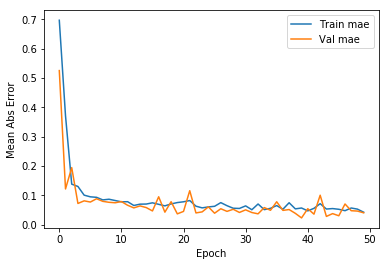

In [16]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train mae')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val mae')
plt.legend()

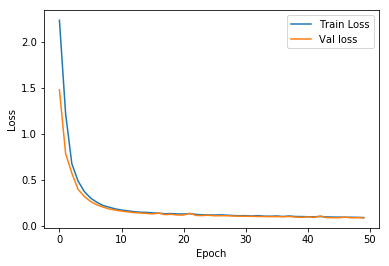

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, np.array(history.history['loss']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
       label = 'Val loss')
plt.legend()

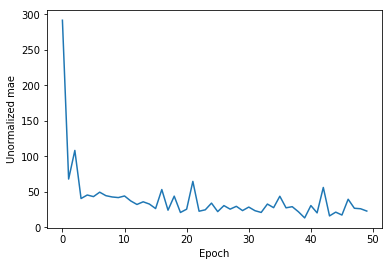

In [18]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Unormalized mae')
plt.plot(history.epoch, val_umae)

# Likelihood metrics

In [19]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

428 µs ± 9.83 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 428.004306


In [20]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

3.83 ms ± 65.2 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)
Likelihood prediction time (micro-seconds): 3833.404239


In [21]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 540.40120


In [22]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 525.74699


# Comparing MCMC run times

In [23]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [24]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [25]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([0.10724896, 0.508822  , 2.98961521]),
 array([0.10832144, 0.51391022, 3.01951137]),
 array([0.10617647, 0.50373378, 2.95971906])]

In [26]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [27]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


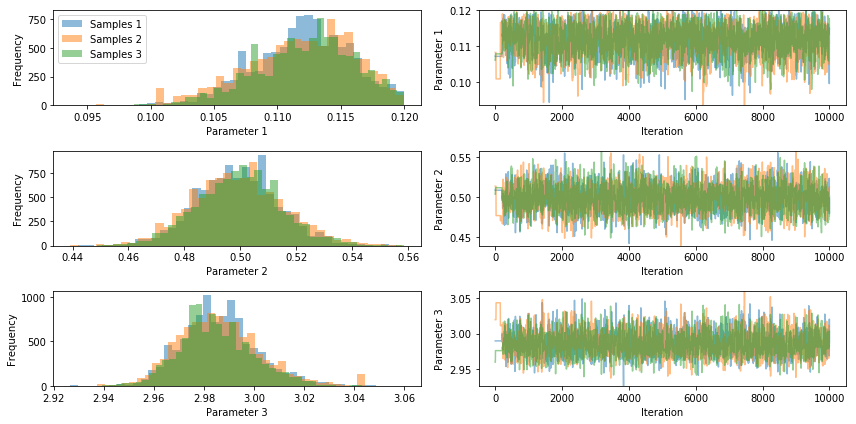

In [28]:
pints.plot.trace(emu_chains)
plt.show()

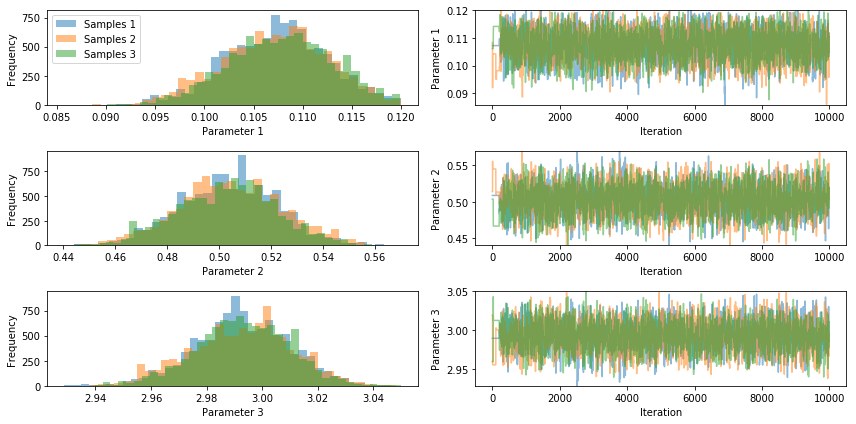

In [29]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [30]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[1.0017804153586667, 1.000258501567839, 1.0016095346223297]


In [31]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.0019049755262444, 1.000813104667715, 1.0001502620246392]


In [32]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 4.58500


In [33]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

19.6 s ± 4.92 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 19.64977


In [34]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

2min 10s ± 12.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 130.42598


In [35]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [0.11194979 0.49931828 2.98578933]
Emulator parametet std:  [0.00021486 0.00074572 0.00100887]


In [36]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Estimated parameters: ", real_parameters)
print("parametet std: ", real_parameters_std)

Estimated parameters:  [0.10739001 0.5037812  2.99286942]
parametet std:  [7.55948241e-05 5.28390280e-04 7.73168070e-04]


# Plotting emulator surfaces around parameters

In [37]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

In [38]:
bounds

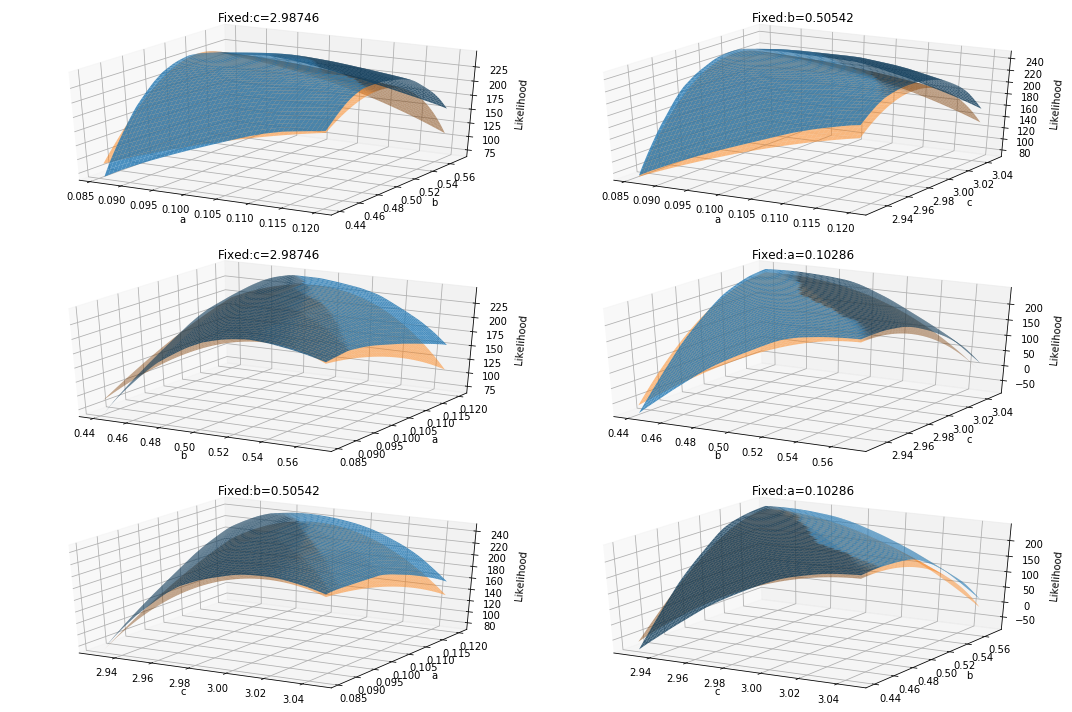

In [39]:
# plot surfaces
if n_parameters >= 3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [40]:
print(bounds.lower())
print(bounds.upper())

[0.08574181 0.44083223 2.92867602]
[0.11997433 0.57001062 3.04623425]


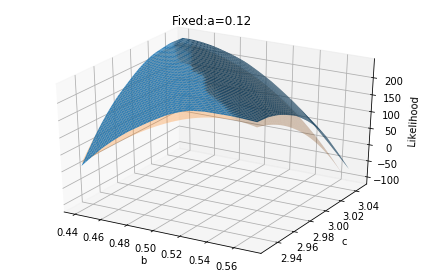

In [41]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    #fixed = [(1, 0.29)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

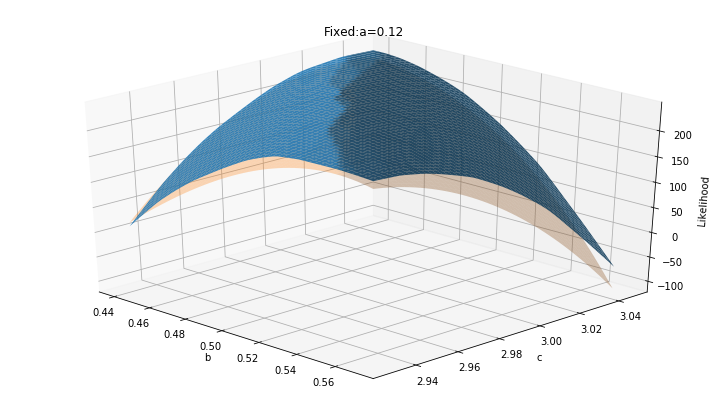

In [42]:
ax.view_init(30, 45 + 90 *3)
fig.set_size_inches(10.5, 6)
fig